# Hyperparameter Optimization
Evan Komp
DSMCER Guest Lecture 03.03.22
***

### Run below if using this notebook for the first time
*Make sure you have the proper environment activated!*

In [ ]:
!conda install -c conda-forge numpy scikit-learn optuna seaborn matplotlib -y

***
### Imports

In [2]:
# data handling
import numpy as np
import sklearn.datasets

#plotting
import matplotlib.pyplot as plt
import matplotlib.animation

#models
import sklearn.tree

# hyperparameter optimization
import optuna
import sklearn.model_selection
import sklearn.preprocessing

***
### Warm up ... 

Name some hyperparameters you might have for a neural network.

## Why optimize hyperparameters?

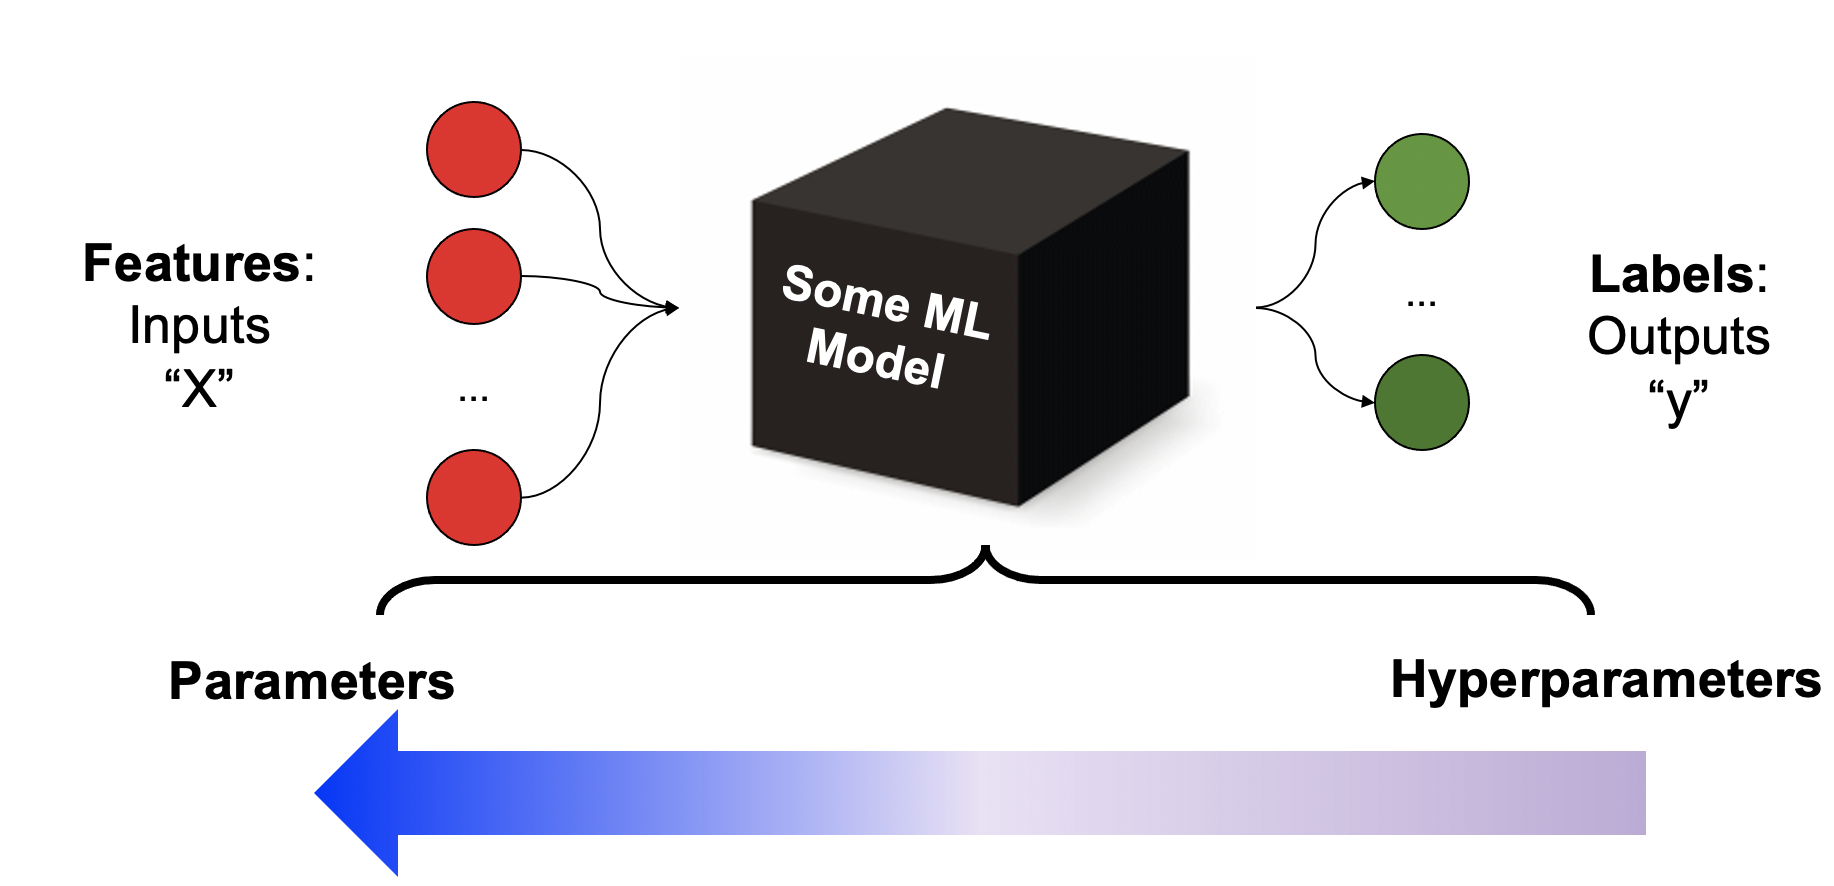

In math, we are trying to create a predictor

$$\hat{y} = f(X;\theta,\Omega)$$

for parameters $\theta$ and hyperparamers $\Omega$, such that

$$\textrm{loss}(y,\hat{y})$$

Is optimized.

Now let's say we have some hyperparameters $\Omega$, what is the process of determining the best parameters called? Eg.

$$\theta^* = \textrm{argmin}_\theta [\textrm{loss}(y,f(X;\theta,\Omega)))]$$

How would you do it for a linear regressor?

> This is called training. For a linear regressor, we would use least squares to analytically determine the best coefficients.

## Loss surface

Each model has a loss surface, and the best parameters $\theta^*$ is associated with somewhere on this surface. Here it is shown in the context of DNNs where $w$ are the neuron weights, $b$ are the neuron biases, and $\phi$ are some mapping of these to one dimension. Thus all model parameters $\theta$ are shown in two dimensions.

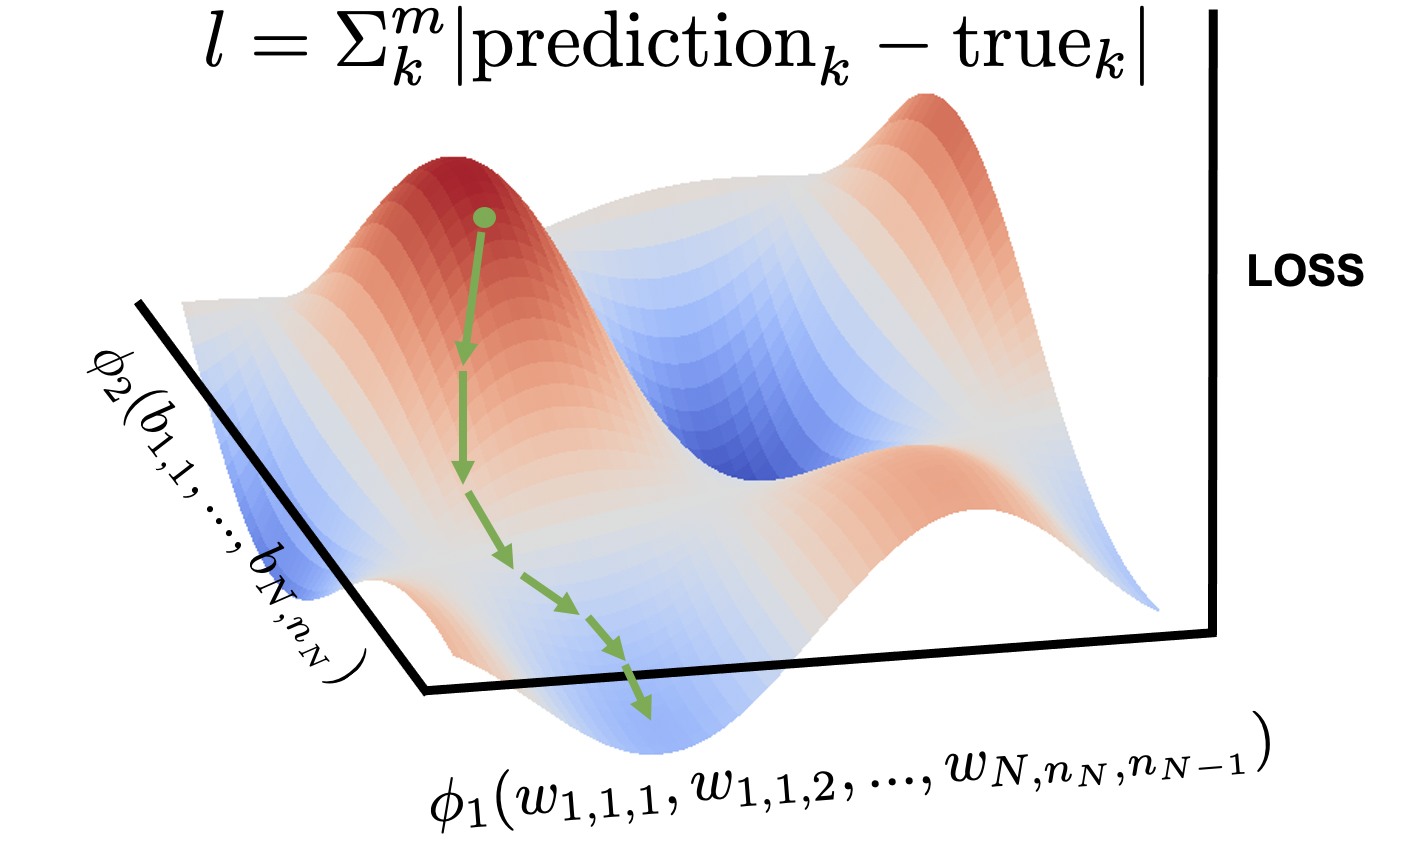

How many dimensions is this surface?

> The loss surface has dimensions equal to the number of parameters

Our goal again is to find the lowest point on this surface. For neural nets, optimizers are used to search this surface for the optimal parameters $\theta^*$ (Green arrows above). Some examples of these are:
- Stochastic Gradient Descent
- RMS Prop
- Adam

We will not dive into the math of any of these, but I encourage you to explore these on your own time. At a high level, all of these are gradient descent models, eg. they change parameters by following the steepest path down this surface.

Critically what does this imply about the loss surface?

> It is differentiable. Neural networks are design so that this is the case - it is a bunch of linear sums and analytical-derivative activation functions.

__Important takeaway__: This loss surface is *deterministic* for some set of data and some set of hyperparameters!

What does this imply about some set of hyperparameters?

> We can evaluate their quality by their loss at the best parameters for that set of hyperparameters. We can imagine a hyperparameter loss surface.

We can imagine a "hyperparameter loss surface":
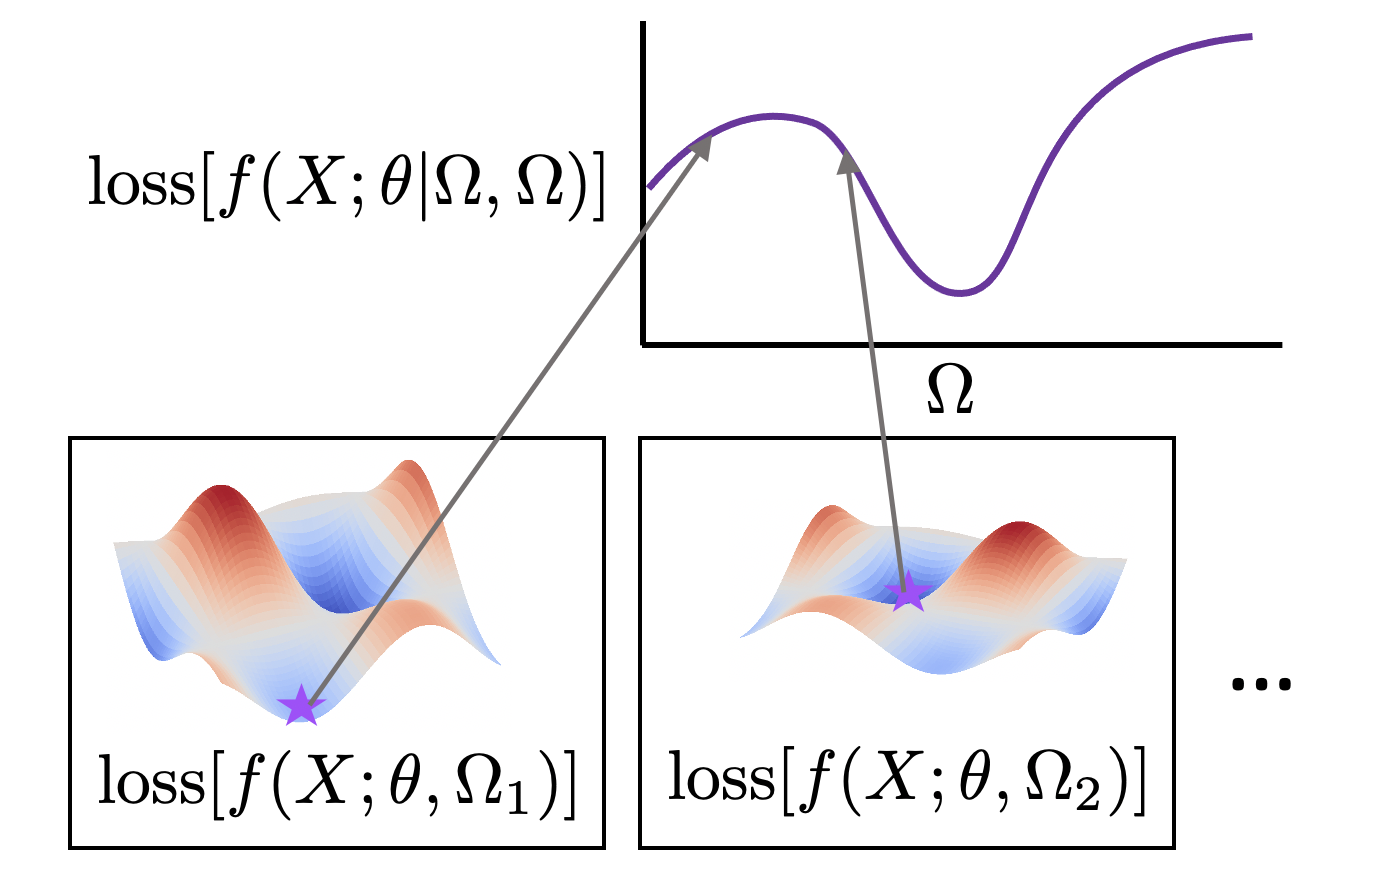

__Important takeaway__: Our model performance is dependant on both its parameters *and* its hyperparameters, so we should optimize over hyperparameters if we want to produce the best model! Note that for DNNs, while the loss surface itself and $\theta^*$ is deterministic, the trained parameters are not, because your optimizer finds a local minimum but is not guaranteed to find the global minumum.

What should we do to find the "best" set of hyperparameters $\Omega^*$?

> The best hyperparameters is not analytical, and the hyperparameter surface is not differentiable, so we can't do gradient descent.

***
## Preparing some data

What is our ultimate goal? To produce a model that...

> Performs well on unseen data. This is why we have a test set, to estimate this.

__Important question__: What is rule number one of training and testing data? What is the justification of this rule?

> They must not overlap. This is because if the model sees testing data during training, it will find parameters that perform deceptively well and not be a good estimate of how well it will perform.

We said we can evaluate the performance of a set of hyperparameters by its trained loss, but on what set of data? Is the loss of the trained model on the training set a good choice? On the testing set?

> If we use the training loss, we do not have a good metric for how well it will perform on new data, if we use the testing loss and use that value to change our parameters, we have effectively broken rule number one.

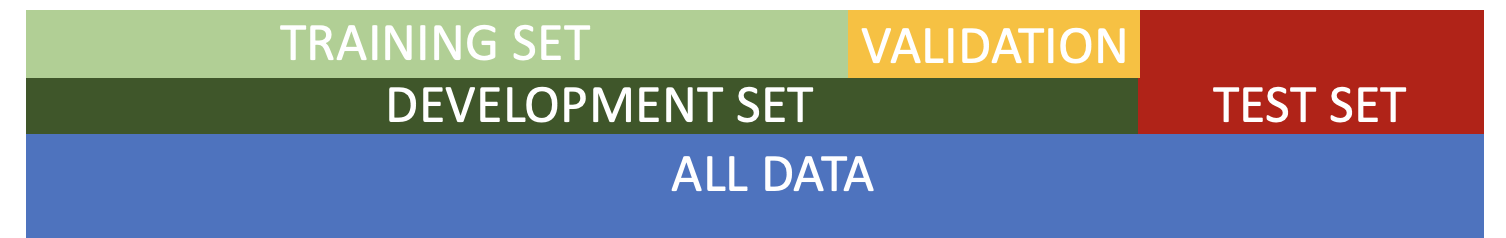

In [3]:
X, y = sklearn.datasets.load_iris(return_X_y=True)

In [4]:
X_dev, X_test, y_dev, y_test = sklearn.model_selection.train_test_split(
    X, y, test_size=0.20, random_state=42)

In [5]:
X_train, X_val, y_train, y_val = sklearn.model_selection.train_test_split(
    X, y, test_size=0.20, random_state=42)

***
## How do we explore hyperparameter space to find the best value?

Demonstration model : `DecisionTreeClassifier`, search for hyperparameters using validation accuracy as the metric.

- `max_depth` $\in \mathbb{N}(1,5)$ 
- `min_weight_fraction_leaf` $\in \mathbb{R}(0.0,0.5)$

### Method 1: Brute force grid search

Algorithm:

1. Discretize continuous hyperparameters on a grid, define hyperparameter options
2. For each combination of hyperparameters, train and evaluate validation performance
3. Output hyperparameter set with the best validation performance


On your own:

In [ ]:
def train_evaluate_hyperparameters(max_depth, min_weight_fraction_leaf):
    # create a model
    # train the model on the test set
    # evaluate the model on the validation set
    return score

In [ ]:
# create hyperparameter value options for each hyperparameter
max_depth_options = ##
min_weight_fraction_options = ##

# create a matrix to store results
validation_score = np.empty(
    (len(max_depth_options), len(min_weight_fraction_options))
)

# for each combination, record the validation score
for i, max_depth in enumerate(max_depth_options):
    for j, min_weight_fraction in enumerate(min_weight_fraction_options):
        validation_score[i,j] = train_evaluate_hyperparameters(max_depth, min_weight_fraction)

One solution

In [6]:
def train_evaluate_hyperparameters(max_depth, min_weight_fraction_leaf):
    model = sklearn.tree.DecisionTreeClassifier(
        max_depth=max_depth, min_weight_fraction_leaf=min_weight_fraction_leaf)
    model.fit(X_train, y_train)
    score = model.score(X_val, y_val)
    return score

In [7]:
# create hyperparameter value options for each hyperparameter
max_depth_options = list(range(1,6))
min_weight_fraction_options = np.linspace(0.0, .5, 10)

# create a matrix to store results
validation_score = np.empty(
    (len(max_depth_options), len(min_weight_fraction_options))
)

# for each combination, record the validation score
for i, max_depth in enumerate(max_depth_options):
    for j, min_weight_fraction in enumerate(min_weight_fraction_options):
        validation_score[i,j] = train_evaluate_hyperparameters(max_depth, min_weight_fraction)

What does our surface look like?

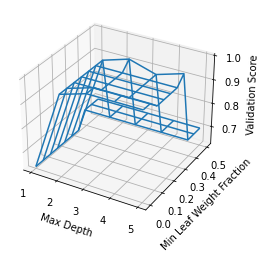

In [8]:
MD, MWF = np.meshgrid(
    np.array(max_depth_options),
    min_weight_fraction_options)
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.plot_wireframe(MD, MWF, validation_score.T, rstride=1, cstride=1)
ax.set_xlabel('Max Depth')
ax.set_ylabel('Min Leaf Weight Fraction')
ax.set_zlabel('Validation Score')
plt.show()


The best hyperparameters:

In [9]:
best_position = np.unravel_index(np.argmax(validation_score), validation_score.shape)
print('Best max_depth: ', max_depth_options[best_position[0]])
print('Best min weight: ', min_weight_fraction_options[best_position[1]])

Best max_depth:  3
Best min weight:  0.0


Do we have to do all of this coding? No... plenty of packages impliment this, including sklearn. It even lets you do cross validation really easily!

Why would we want to do cross validation instead of a single validation set?

> It is a less biased estimation of the hyperparameter's true performance considering unknown data.

In [10]:
param_grid = {
    'max_depth': max_depth_options,
    'min_weight_fraction_leaf': min_weight_fraction_options
}
grid_search = sklearn.model_selection.GridSearchCV(
    sklearn.tree.DecisionTreeClassifier(),
    param_grid,
    cv=5
)
grid_search.fit(X_dev, y_dev)
print('Best hyperparameters: ', grid_search.best_params_)

Best hyperparameters:  {'max_depth': 4, 'min_weight_fraction_leaf': 0.0}


Why did I use the dev set?

> We are doing CV and the grid search will split the dev set into folds.

### Method 2: Brute force random search

Algorithm:

1. Define hyperparameter space
2. For a set of hyperparameters sampled from the space, train and evaluate validation performance
3. Output hyperparameter set with the best validation performance

Let's say you do a grid search and a random search, each for 50 total combinations of hyperparameters, why might random search be desirable?


> It does not repeat hyperparameter values, meaning that for a fixed number of trials, you do more exploration.

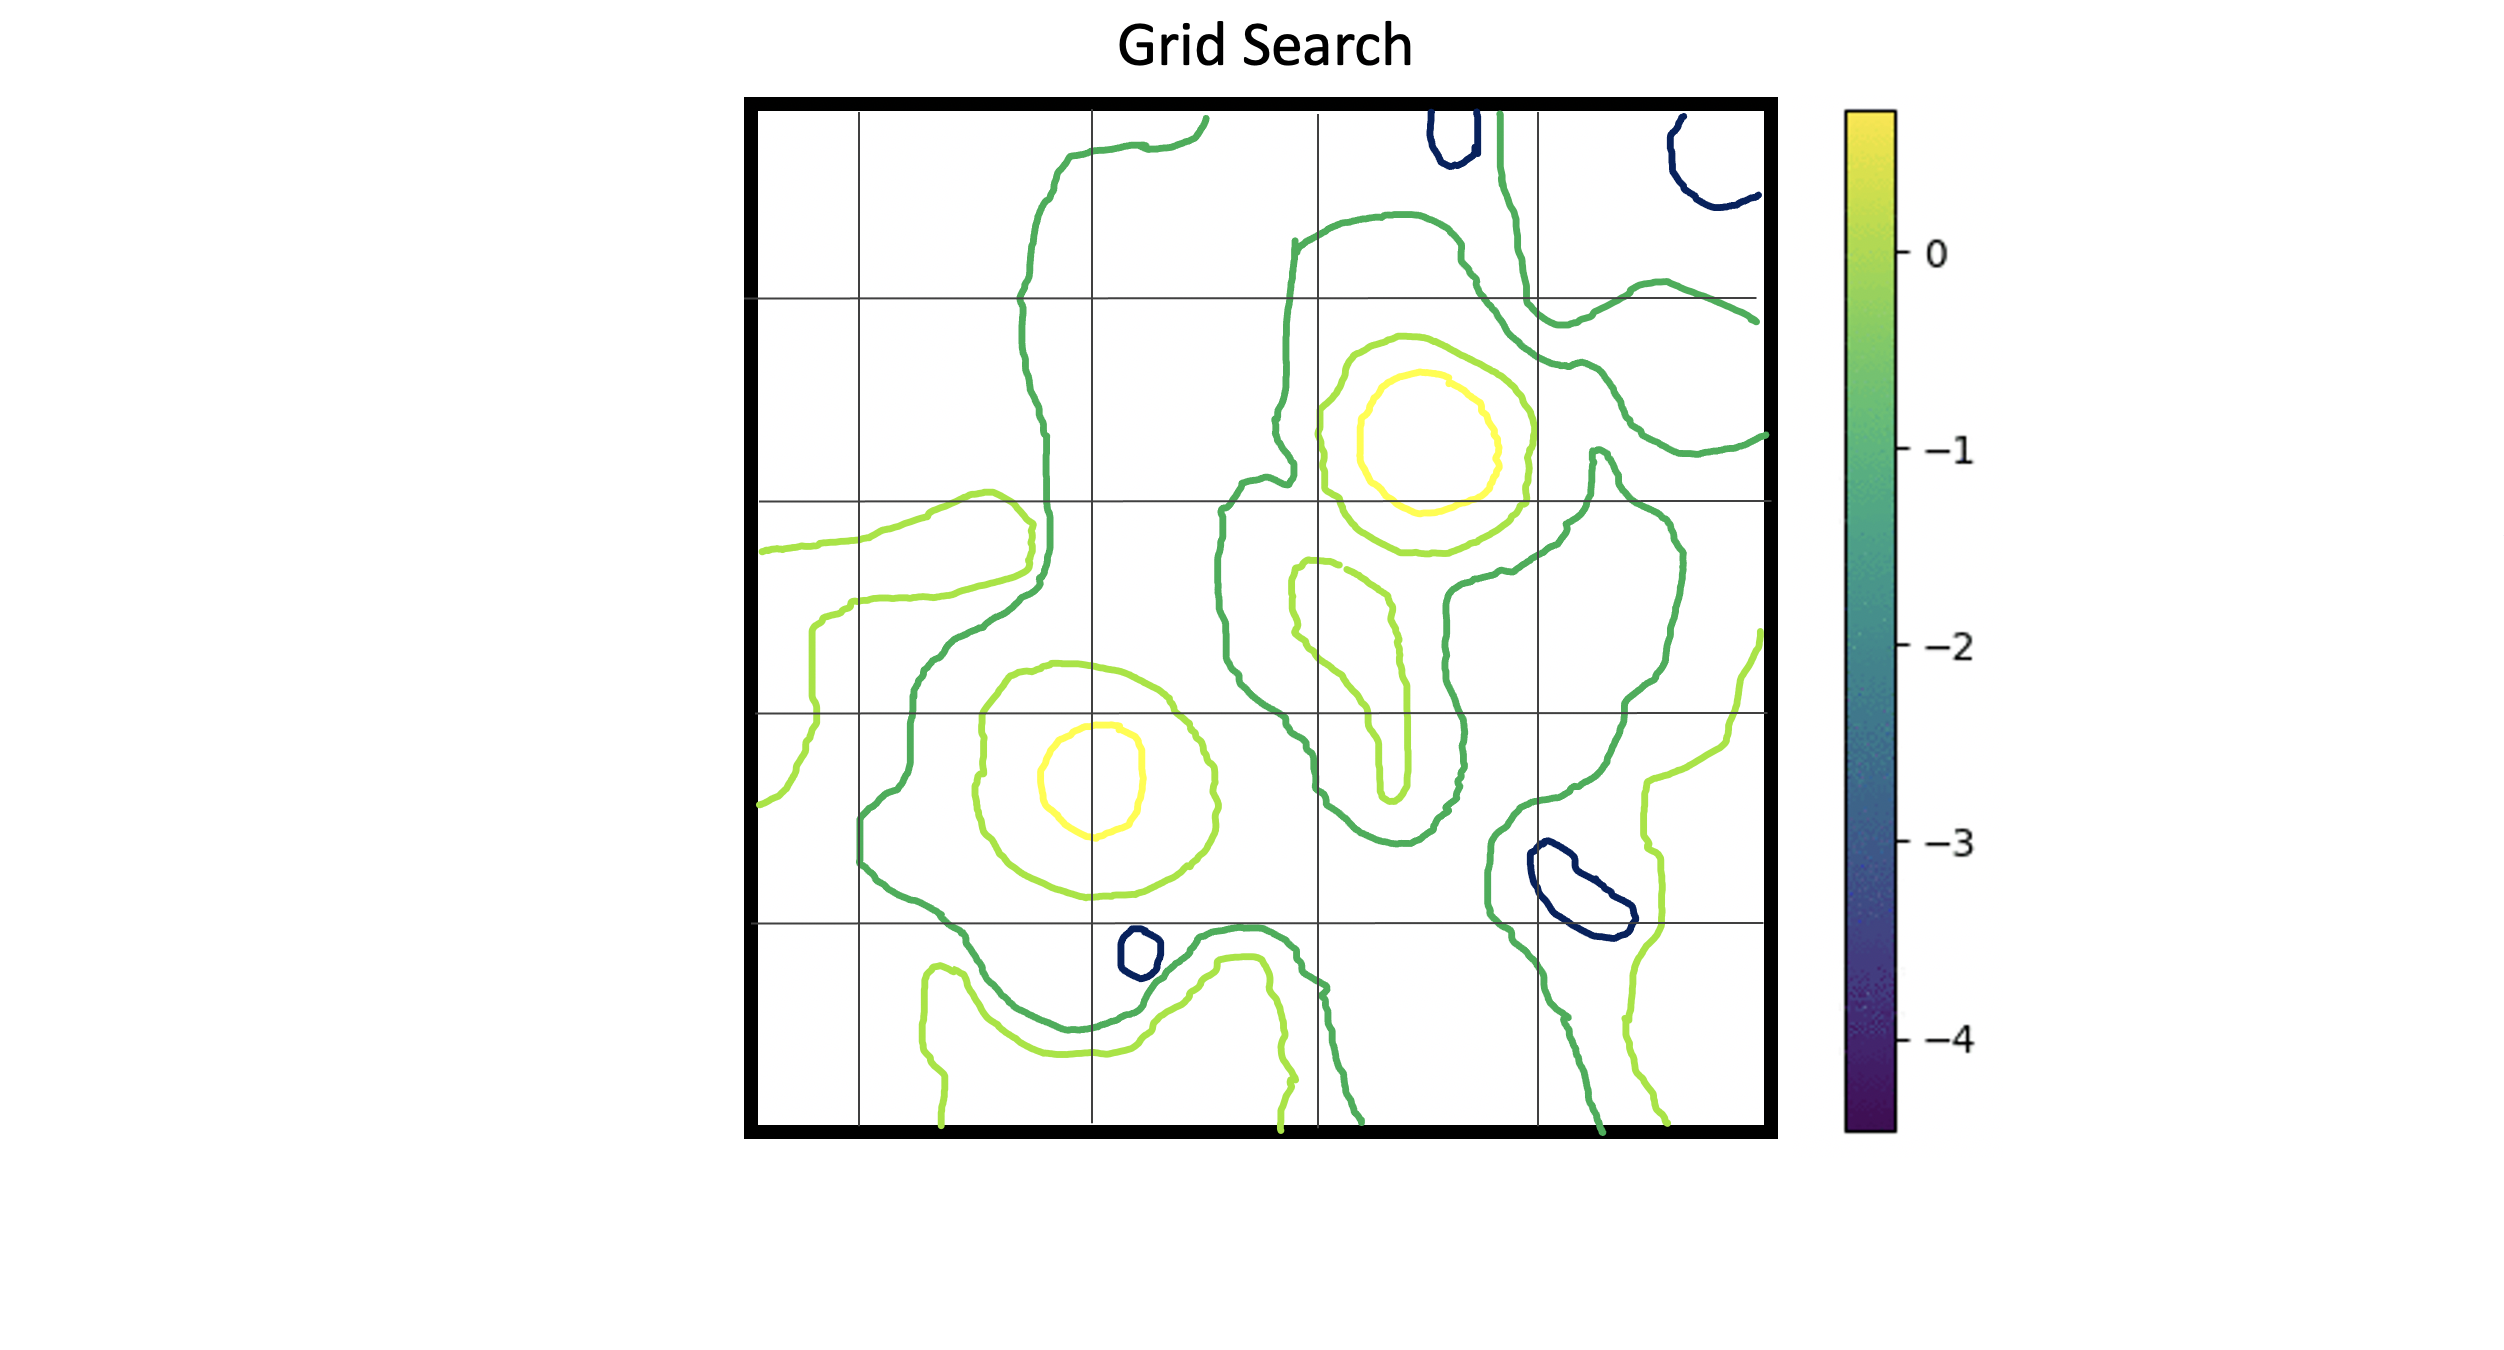
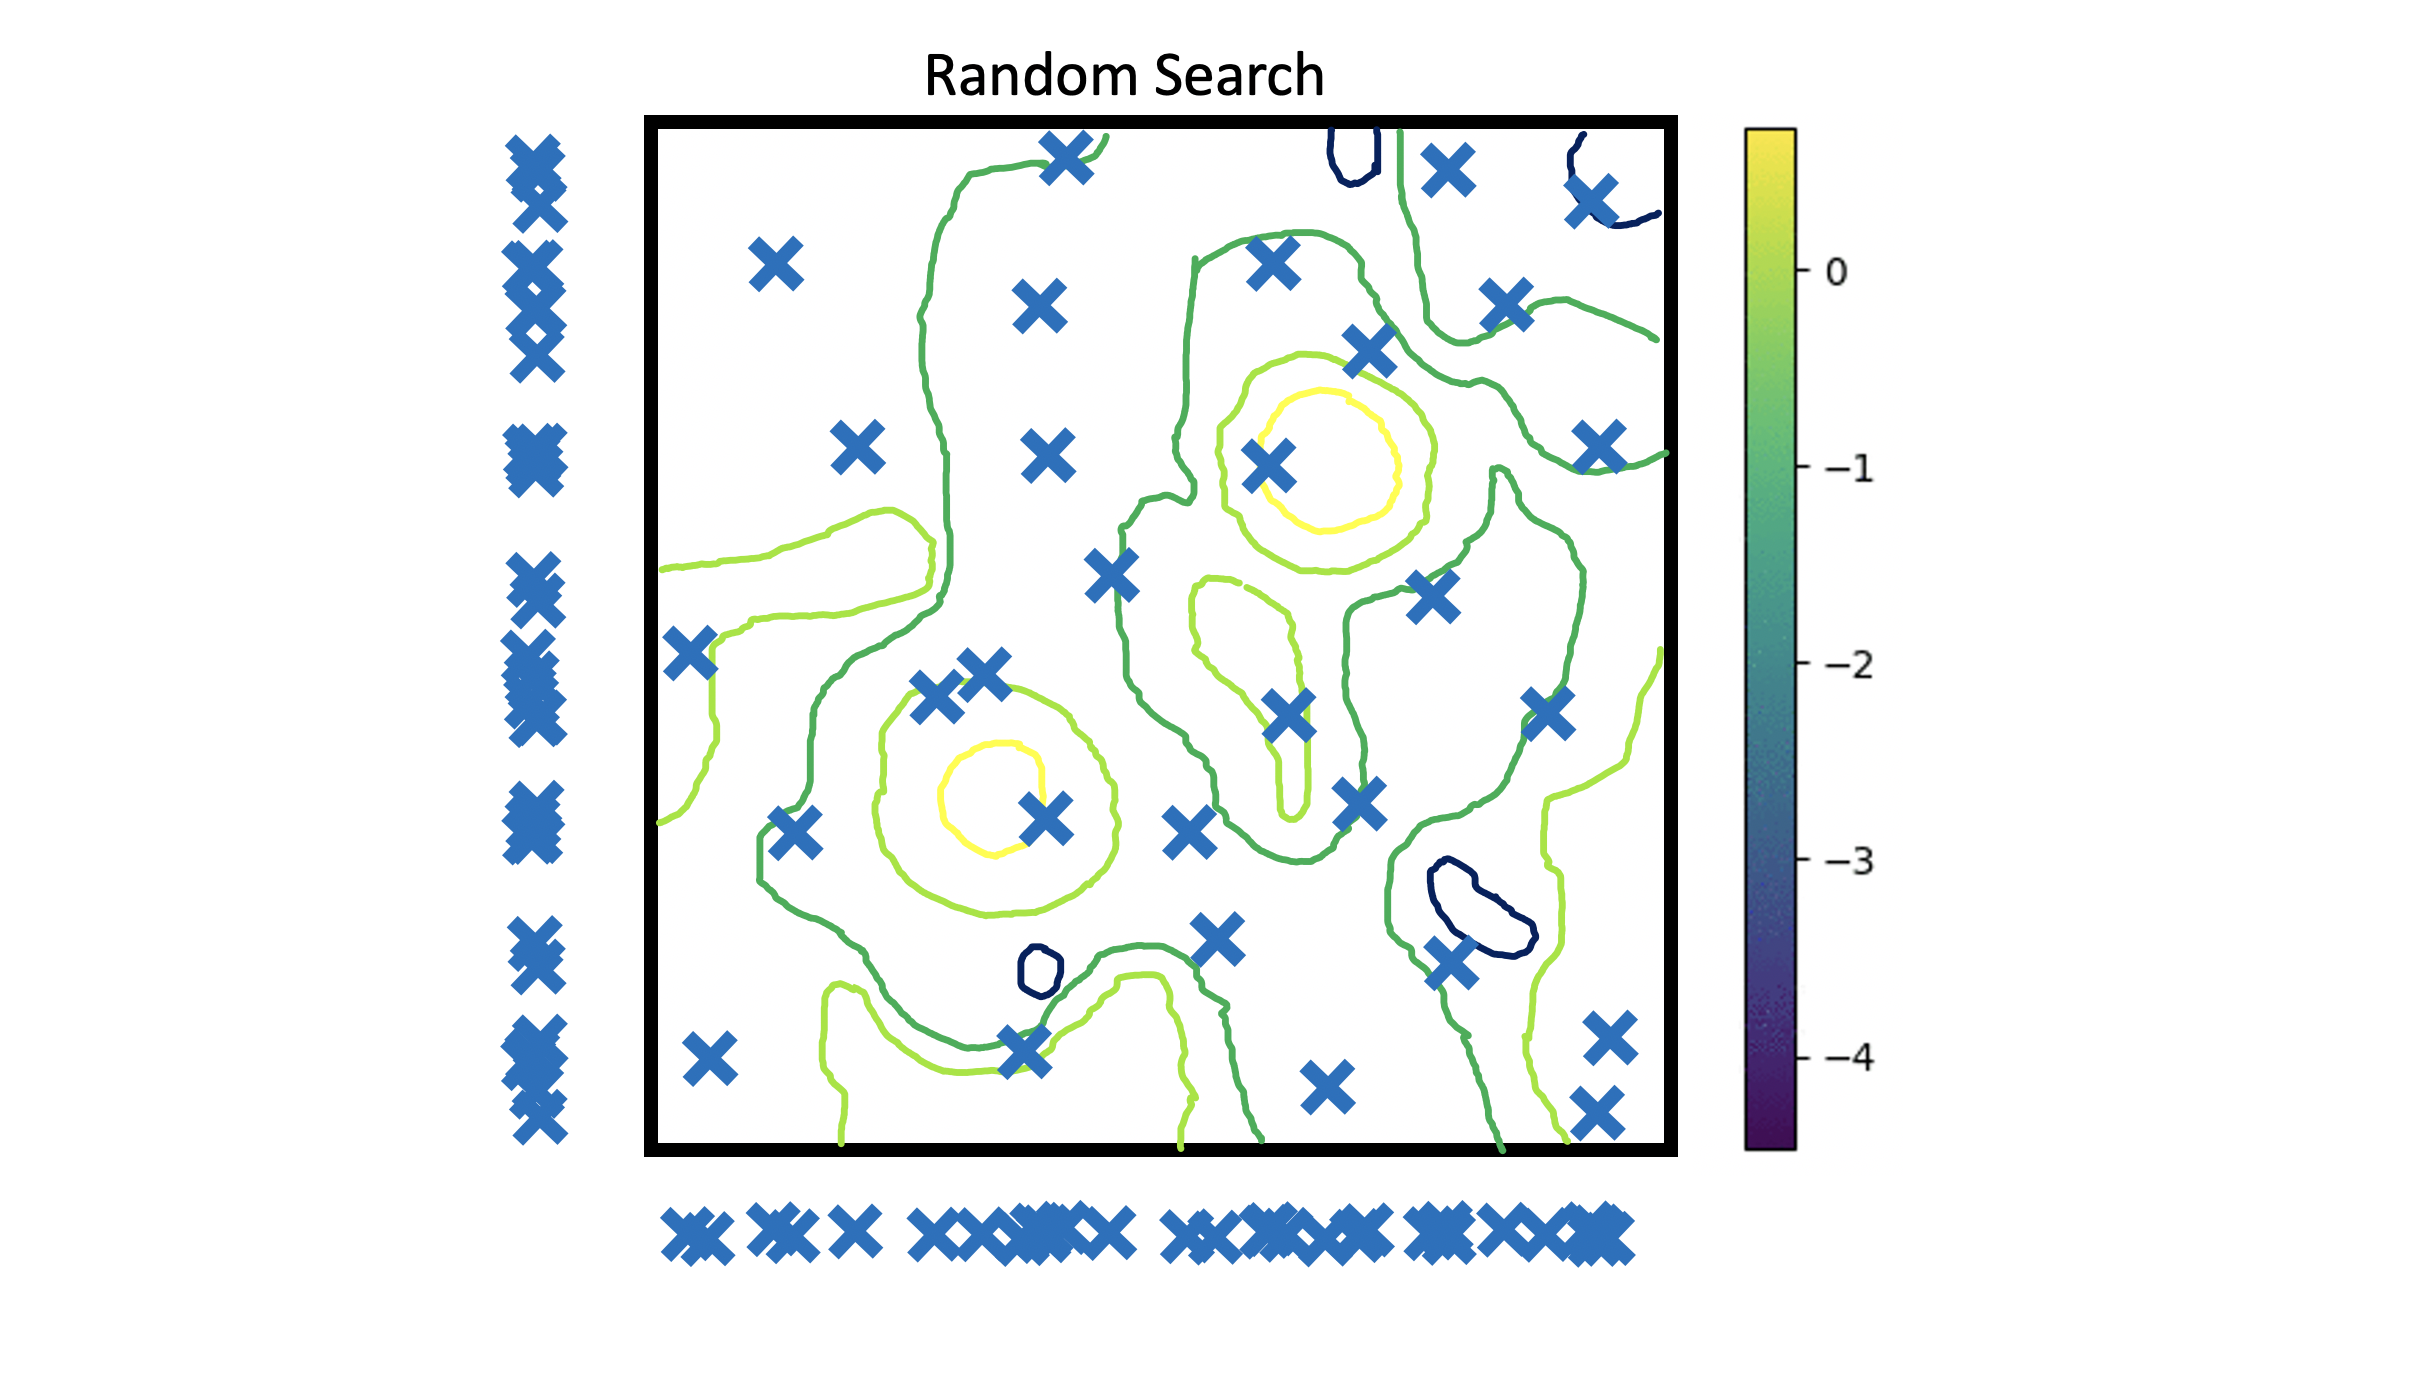

### Method 3: Adaptive Tree Parzen Estimator (TPE)

Algorithm

1. Define hyperparameter ranges that the search is able to operate in
2. Select some hyperparameter values randomly and evaluate them
3. Seperate results into low performing and high performing hyperparameters by some quantile
4. Fit a kernel density estimate to each group
5. Sample the new values of hyperparameters to test from the ratio of good to bad densities
6. Evaluate this new value of hyperparameters, add it to the set of results
7. Repeat 3-6 until a desired validation score is reached or after a certain number of iterations

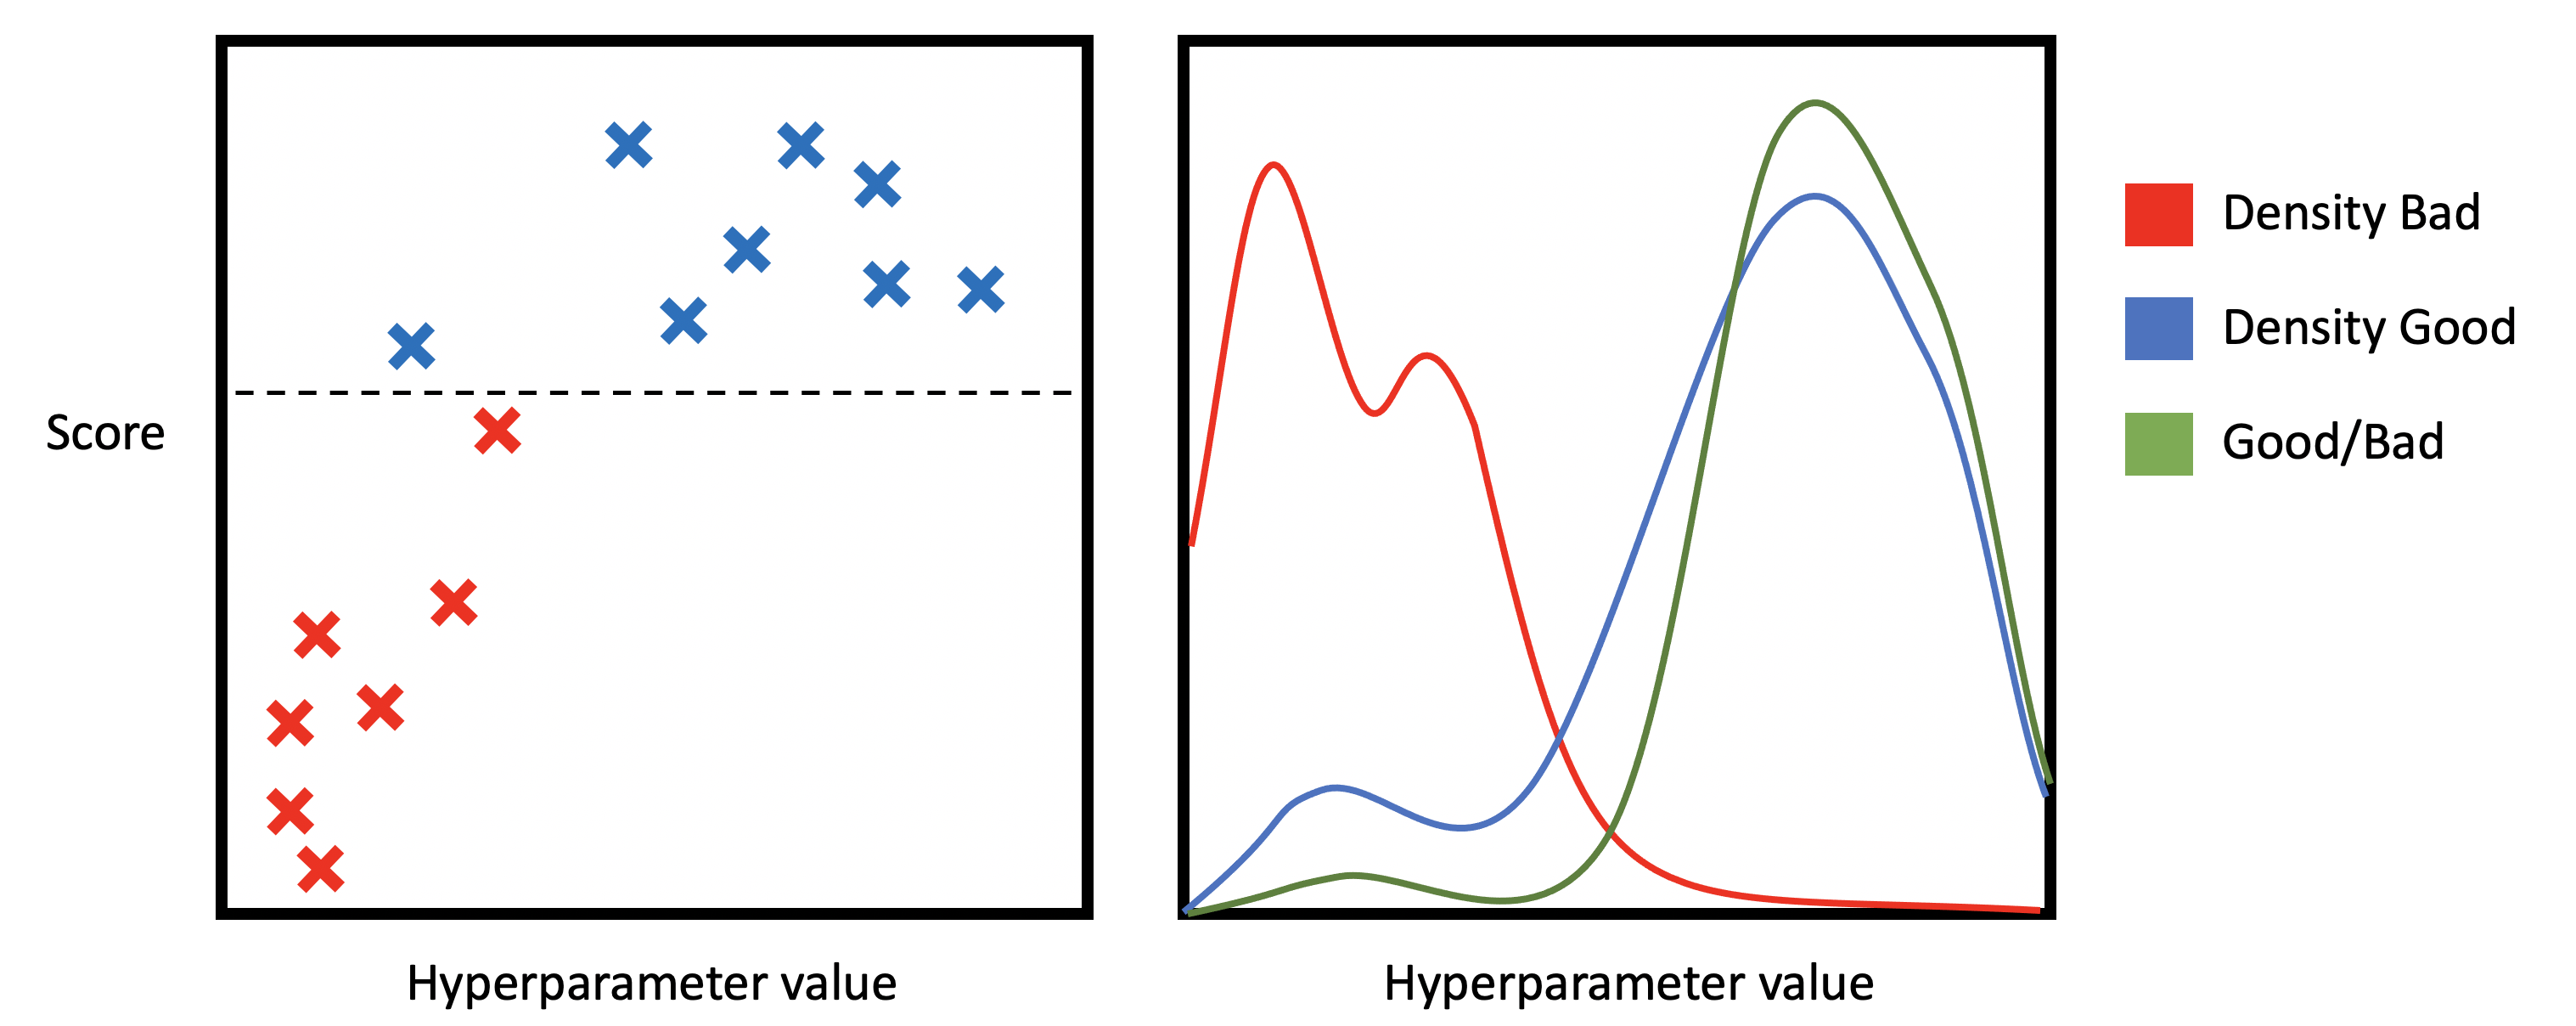

Optuna impliments TPE sampling. Optuna is very general and can be used for many optimization tasks. All we have to do is return an __objective__ function that takes in a set of hyperparameters, and returns a score to minimize or maximize.

Let's demonstrate this on a toy analytical surface in two dimensions:

In [11]:
def two_d_gaussian(x, y, mean=(0,0), std=(1,1)):
    return np.exp(-((x-mean[0])**2/(2*std[0]**2) +(y-mean[1])**2/(2*std[1]**2)))

def analytical_score(x,y):
    return (two_d_gaussian(x, y, mean=(.2,.1), std=(.3,.6)) + 1.2*two_d_gaussian(x, y, mean=(.8,.6), std=(.2,.1)))

Text(0, 0.5, 'y')

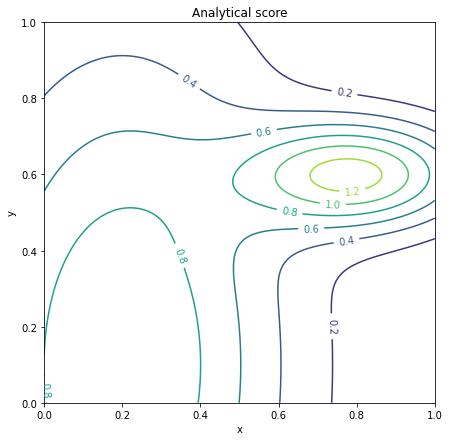

In [12]:
X, Y = np.meshgrid(
    np.linspace(0,1,200),
    np.linspace(0,1,200)
)
Z = analytical_score(X,Y)

fig, ax = plt.subplots(figsize=(7,7))
CS = ax.contour(X, Y, Z)
ax.clabel(CS, inline=True, fontsize=10)
ax.set_title('Analytical score')
ax.set_xlabel('x')
ax.set_ylabel('y')

Let's watch TPE find the best value of $x$ and $y$:

In [13]:
def objective(trial):
    # define hyperparameter space
    x = trial.suggest_float("x", 0.0, 1.0)
    y = trial.suggest_float("y", 0.0, 1.0)
    
    # get the score for the hyperparameters chosen
    score = analytical_score(x,y)
    
    return score

study = optuna.create_study(sampler=optuna.samplers.TPESampler(), direction='maximize')
study.optimize(objective, n_trials=50)
results = study.trials_dataframe()

[I 2022-03-01 20:31:45,862] A new study created in memory with name: no-name-04d1ec21-e168-423c-a5b6-1df68115c938
[I 2022-03-01 20:31:45,864] Trial 0 finished with value: 0.451763531534541 and parameters: {'x': 0.03559016072666876, 'y': 0.7813483614802115}. Best is trial 0 with value: 0.451763531534541.
[I 2022-03-01 20:31:45,865] Trial 1 finished with value: 0.2557015336742601 and parameters: {'x': 0.959333377600172, 'y': 0.7624235380062039}. Best is trial 0 with value: 0.451763531534541.
[I 2022-03-01 20:31:45,866] Trial 2 finished with value: 0.6758851875608595 and parameters: {'x': 0.31182429530438227, 'y': 0.6422794177356}. Best is trial 2 with value: 0.6758851875608595.
[I 2022-03-01 20:31:45,867] Trial 3 finished with value: 0.2693191150980776 and parameters: {'x': 0.9673721689233215, 'y': 0.7565004840642693}. Best is trial 2 with value: 0.6758851875608595.
[I 2022-03-01 20:31:45,868] Trial 4 finished with value: 0.8998716569653327 and parameters: {'x': 0.9121654787628203, 'y': 

In [14]:
results

number     value             datetime_start          datetime_complete  \
0        0  0.451764 2022-03-01 20:31:45.863629 2022-03-01 20:31:45.864048   
1        1  0.255702 2022-03-01 20:31:45.864799 2022-03-01 20:31:45.865079   
2        2  0.675885 2022-03-01 20:31:45.865979 2022-03-01 20:31:45.866310   
3        3  0.269319 2022-03-01 20:31:45.867056 2022-03-01 20:31:45.867401   
4        4  0.899872 2022-03-01 20:31:45.868131 2022-03-01 20:31:45.868425   
5        5  0.163780 2022-03-01 20:31:45.869296 2022-03-01 20:31:45.869598   
6        6  0.432500 2022-03-01 20:31:45.870387 2022-03-01 20:31:45.870746   
7        7  0.552949 2022-03-01 20:31:45.871503 2022-03-01 20:31:45.871804   
8        8  0.355218 2022-03-01 20:31:45.872609 2022-03-01 20:31:45.872885   
9        9  0.224093 2022-03-01 20:31:45.873656 2022-03-01 20:31:45.873910   
10      10  0.588077 2022-03-01 20:31:45.874554 2022-03-01 20:31:45.879577   
11      11  0.780538 2022-03-01 20:31:45.880508 2022-03-01 20:31:45.885025   
12      12  0.757856 2022-03-01 20:31:45.885866 2022-03-01 20:31:45.890167   
13      13  0.530017 2022-03-01 20:31:45.890869 2022-03-01 20:31:45.896137   
14      14  0.735727 2022-03-01 20:31:45.896827 2022-03-01 20:31:45.902111   
15      15  0.096966 2022-03-01 20:31:45.902851 2022-03-01 20:31:45.907206   
16      16  0.748380 2022-03-01 20:31:45.907889 2022-03-01 20:31:45.913121   
17      17  0.118377 2022-03-01 20:31:45.913783 2022-03-01 20:31:45.918328   
18      18  0.998469 2022-03-01 20:31:45.918991 2022-03-01 20:31:45.923311   
19      19  0.986530 2022-03-01 20:31:45.923953 2022-03-01 20:31:45.928327   
20      20  0.984301 2022-03-01 20:31:45.928935 2022-03-01 20:31:45.933259   
21      21  0.982328 2022-03-01 20:31:45.933838 2022-03-01 20:31:45.938507   
22      22  0.993321 2022-03-01 20:31:45.939093 2022-03-01 20:31:45.943357   
23      23  0.726620 2022-03-01 20:31:45.944121 2022-03-01 20:31:45.948568   
24      24  0.997263 2022-03-01 20:31:45.949165 2022-03-01 20:31:45.953781   
25      25  0.919896 2022-03-01 20:31:45.954399 2022-03-01 20:31:45.959331   
26      26  0.961679 2022-03-01 20:31:45.960092 2022-03-01 20:31:45.964664   
27      27  0.407205 2022-03-01 20:31:45.965242 2022-03-01 20:31:45.970130   
28      28  0.716427 2022-03-01 20:31:45.970719 2022-03-01 20:31:45.975574   
29      29  0.869603 2022-03-01 20:31:45.976285 2022-03-01 20:31:45.982760   
30      30  0.841510 2022-03-01 20:31:45.983698 2022-03-01 20:31:45.988958   
31      31  0.994626 2022-03-01 20:31:45.989638 2022-03-01 20:31:45.994519   
32      32  0.998876 2022-03-01 20:31:45.995269 2022-03-01 20:31:46.000639   
33      33  0.885490 2022-03-01 20:31:46.001316 2022-03-01 20:31:46.005948   
34      34  0.951214 2022-03-01 20:31:46.006541 2022-03-01 20:31:46.011426   
35      35  0.829084 2022-03-01 20:31:46.012116 2022-03-01 20:31:46.016726   
36      36  0.942031 2022-03-01 20:31:46.017385 2022-03-01 20:31:46.026331   
37      37  0.831501 2022-03-01 20:31:46.027411 2022-03-01 20:31:46.032638   
38      38  0.970687 2022-03-01 20:31:46.033332 2022-03-01 20:31:46.038148   
39      39  0.963088 2022-03-01 20:31:46.038837 2022-03-01 20:31:46.045218   
40      40  0.910444 2022-03-01 20:31:46.046165 2022-03-01 20:31:46.052115   
41      41  0.991360 2022-03-01 20:31:46.052897 2022-03-01 20:31:46.059681   
42      42  0.982197 2022-03-01 20:31:46.060458 2022-03-01 20:31:46.067075   
43      43  0.955553 2022-03-01 20:31:46.068065 2022-03-01 20:31:46.073778   
44      44  0.907405 2022-03-01 20:31:46.074558 2022-03-01 20:31:46.080182   
45      45  0.621544 2022-03-01 20:31:46.081077 2022-03-01 20:31:46.087306   
46      46  0.977907 2022-03-01 20:31:46.088063 2022-03-01 20:31:46.092859   
47      47  0.923971 2022-03-01 20:31:46.093859 2022-03-01 20:31:46.100032   
48      48  0.739341 2022-03-01 20:31:46.101101 2022-03-01 20:31:46.106181   
49      49  0.953787 2022-03-01 20:31:46.106977 2022-03-01 20:31:46.114175   

                 duration

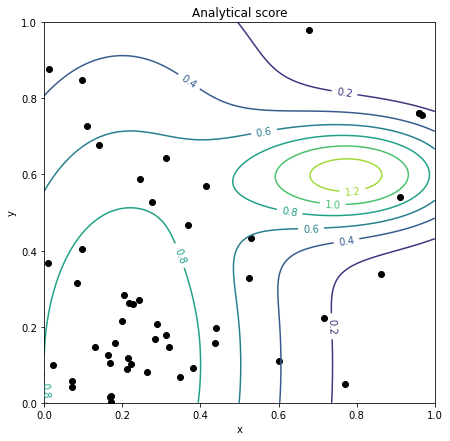

In [15]:
X, Y = np.meshgrid(
    np.linspace(0,1,200),
    np.linspace(0,1,200)
)
Z = analytical_score(X,Y)

fig, ax = plt.subplots(figsize=(7,7))
CS = ax.contour(X, Y, Z)
ax.clabel(CS, inline=True, fontsize=10)
ax.set_title('Analytical score')
ax.set_xlabel('x')
ax.set_ylabel('y')

# animate the trials tested
def animate(i):
    ax.scatter(results.loc[i, 'params_x'], results.loc[i, 'params_y'], color='k')
    
anim = matplotlib.animation.FuncAnimation(fig, animate, frames=range(1, len(results)), interval=1000, repeat=False)
anim.save('animation.gif', writer='pillow', fps=3)

Optuna has a number of ways to select hyperparameters:
- `suggest_uniform` for continuous hyperparameters uniformly
- `suggest_loguniform` for continuous hyperparameters uniformly on the log scale
- `suggest_discrete_uniform` for continuous hyperparameters that should be sampled from a grid
- `suggest_categorical` for discrete hyperparameters
- `suggest_int` for integer hyperparameters

Impliment a TPE search for the the `DecisionTreeClassifier`, search for

- `max_depth` $\in \mathbb{N}(1,5)$ 
- `min_weight_fraction_leaf` $\in \mathbb{R}(0.0,0.5)$

Use validation accuracy again as a metric. Run it for 50 trials. What are the best parameters identified this way?

In [ ]:
def objective(trial):
    # define hyperparameter space
    
    # get the score for the hyperparameters chosen
    
    return score

study = optuna.create_study(sampler=optuna.samplers.TPESampler(), direction='maximize')
study.optimize(objective, n_trials=50)
print('Best params: ', study.best_params)

One solution

In [16]:
def objective(trial):
    # define hyperparameter space
    max_depth = trial.suggest_int('max_depth', 1, 5)
    min_weight_fraction_leaf = trial.suggest_uniform(
        'min_weight_fraction_leaf', 0.0, 0.5)
    
    # get the score for the hyperparameters chosen
    score = train_evaluate_hyperparameters(max_depth, min_weight_fraction_leaf)
    return score

study = optuna.create_study(sampler=optuna.samplers.TPESampler(), direction='maximize')
study.optimize(objective, n_trials=50)
print('Best params: ', study.best_params)

[I 2022-03-01 20:32:09,775] A new study created in memory with name: no-name-ebff3627-c5ea-4d14-b5ad-7fa29ed5abd4
[I 2022-03-01 20:32:09,778] Trial 0 finished with value: 0.9666666666666667 and parameters: {'max_depth': 5, 'min_weight_fraction_leaf': 0.09177652018615773}. Best is trial 0 with value: 0.9666666666666667.
[I 2022-03-01 20:32:09,779] Trial 1 finished with value: 0.9666666666666667 and parameters: {'max_depth': 5, 'min_weight_fraction_leaf': 0.12031688537538754}. Best is trial 0 with value: 0.9666666666666667.
[I 2022-03-01 20:32:09,781] Trial 2 finished with value: 0.9666666666666667 and parameters: {'max_depth': 5, 'min_weight_fraction_leaf': 0.11994151310299461}. Best is trial 0 with value: 0.9666666666666667.
[I 2022-03-01 20:32:09,783] Trial 3 finished with value: 0.7 and parameters: {'max_depth': 5, 'min_weight_fraction_leaf': 0.48352842700059506}. Best is trial 0 with value: 0.9666666666666667.
[I 2022-03-01 20:32:09,784] Trial 4 finished with value: 0.96666666666666

Best params:  {'max_depth': 4, 'min_weight_fraction_leaf': 0.0018407018203615844}


In the same number of trials as Grid Search, we found a more fine tuned value of our continuous hyperparameter `min_weight_fraction_leaf` which in grid search could only take specific values on a grid!

## Some other useful tools

If you are interested, reach out.

1. Using an adaptive search like TPE is most important when your objective function takes a long time to evaluate. For example, if you have a large dataset and a very deep neural network, training an evaluation can take on the order of hours, so finding the best parameters with as few trials as possible is important.
2. Optuna Grid, Random, TPE and other adaptive algorithms implemented.
3. You can use "pruning" to reduce your trial time. Optuna supports this. This is where you evaluate your tenative performance periodically before your model is fully trained. Assuming that a model performing poorly eg. halfway through training won't suddenly become the best, you can stop training and move on. Some criteria is used eg "If a model at 10 epochs is performing in the bottom 25% of models at 10 epochs, cut it."
4. You can run hyperparameter searches in parallel. Instead of trying one set of hyperparameters and then moving on, try a number at the same time. For example, with 4 cores on your CPU you can do 4 trials simultaneously.